# Index

1. [Object-oriented implementation](#impl) of the nodes under the specified design    
    1. Implementation of a [generic node](#implN) $\mathcal{N}$
    2. Implementation of [an $\mathcal{M}$ node](#implM)
    3. Implementation fo [an $\mathcal{S}$ node](#implS)
2. Implementation of a [simple channel](#implCh) for two nodes to comunicate
3. [Testing](#test)
    1. Extracting [reference values](#ref_val) from Dwivedi, De Angelis, Zachariah and Händel (2015)
    2. [Running examples](#run) for toy values and validating our model
        1. [Noise-less](#noise-less) case
        2. [Noisy](#noisy) case (Fig. 3 of our paper)

<a id="impl"></a>
# Object-oriented implementation of the nodes under the specified design

|<img src="../figs/node_internals.jpg" alt="drawing" width="300"/>|
| --:-- |
|<center>Fig. 1: * Internal design of any node $\mathcal{N}$ considered throughout the paper. This design uses an independent time-to-digital converter (TDC) to accurately measure round-trip times (RTT). The resulting node $\mathcal{N}$ can measure RTTs with a much finer time-resolution than it can react to incoming pulses. Indeed, in order to react to an incoming pulse, $\mathcal{N}$ must first access the TDC’s  memory, process the reading, and decide to send a pulse, all of which require waiting until its next clock cycle. *</center>|

<a id="implN"></a>
## Implementation of a generic node $\mathcal{N}$

In [1]:
import numpy as np

class node:
    """A node in a network with a TDC"""
    
    def __init__( self, identifier, clock_period = 100, jitter_std = 0.2, offset = None, channel_instance = None ):
        
        # Load direct parameters
        # Identifier 
        self.id = identifier
        # Clock period
        self.clock_period = clock_period
        # Jitter in the computation of the next upflank
        self.jitter_std = jitter_std
        # Initial delay, corresponding to the node's clock phase
        if not offset == None:
            self.offset = offset
        else:
            self.offset = np.round( self.clock_period * np.random.random( ) )
        # Channel to send messages through
        self.channel = None
        
        # Compute indirect parameters
        # Compute time to the next clock upflank
        self.time_to_next_clock_event = np.round( - self.offset
                                  + self.clock_period 
                                  + self.jitter_std * np.random.randn( ) )
        
        # Initialize necessary variables
        # Reference time counter, at the resolution of the TDC
        self.time = 0       
        # Measurement buffer, where measurements made by the TDC are stored.
        self.tdc_buffer = np.array( [] )
        # Current length of the measurement buffer
        self.nrof_TDC_measurements = 0
        # Times at which packages have been sent
        self.sending_times = np.array( [] )
        # Clock signal (0 always except in upflanks)
        self.clock_signal = 0
    
    # Simulate the arrival of a pulse
    def pulse_arrival( self ):
        # If a pulse arrives and it is not an answer to any message
        if self.sending_times.size == self.nrof_TDC_measurements:
            # Add a fictitious sending at time nan (the RTT will also be nan)
            self.sending_times = np.append( self.sending_times, np.nan )
        # Store RTT
        self.tdc_buffer = np.append( self.tdc_buffer, self.time 
                                     - self.sending_times[self.nrof_TDC_measurements] )
        # Increment the counter of RTT measurements
        self.nrof_TDC_measurements += 1
    
    # Simulate the sending of a pulse
    def send_pulse( self ):
        if not self.channel == None:
            # Send the a pulse to the channel with the node's unique id
            self.channel.send( self.id )
            # Remember the pulse has been sent (start TDC measurement)
            self.sending_times = np.append( self.sending_times, self.time )
        else:
            print( 'Node not ready, missing a communication medium. Use set_channel( channel ).' )
    
    # Configure the node to use a specific channel instance
    def set_channel( self, channel_instance):
        self.channel = channel_instance
    
    # Pass one time unit of the TDC
    def pass_time( self ):
        # Add to TDC time
        self.time += 1
        # Decrease time to next clock upflank
        self.time_to_next_clock_event -= 1
        # If we are at an upflank, act accordingly
        if self.time_to_next_clock_event == 0:
            # Notify inheriting classes
            self.clock_signal = 1
            # Set the time to the next upflank, with possible randomness
            self.time_to_next_clock_event = np.round(  self.clock_period 
                                     + self.jitter_std * np.random.randn( ) )
        else:
            # Notify inheriting classes
            self.clock_signal = 0


<a id="implM"></a>
## Implementation of an $\mathcal{M}$ node

In [2]:
class node_M( node ):
    """A node in a network with a TDC acting like M in the described RTT protocol"""
    
    def __init__( self, sampling_factor = 2, *args, **kwargs ):
        # Initialize object as a node
        super(node_M, self).__init__( identifier = 'M', *args, **kwargs )
        # Include sampling factor
        self.sampling_factor = sampling_factor
        # Include periods to next ping (tweak to always sample at first period)
        self.periods_to_next_ping = 1
    
    # Specify behavior of an M node
    def pass_time( self ):
        # Pass time as a node
        super( node_M, self ).pass_time( )
        # If the current time is an upflank
        if self.clock_signal == 1:
            self.periods_to_next_ping -= 1
            # If it is time to send a ping
            if self.periods_to_next_ping == 0:
                self.send_pulse( )
                self.periods_to_next_ping = self.sampling_factor


<a id="implS"></a>
## Implementation of an $\mathcal{S}$ node

In [3]:
class node_S( node ):
    """A node in a network with a TDC acting like S in an RTT protocol"""
    
    def __init__( self, delay_factor = 1, *args, **kwargs ):
        # Initialize object as a node
        super( node_S, self ).__init__( identifier = 'S', *args, **kwargs )
        # Include delay factor (minimum 1)
        self.delay_factor = delay_factor
        # Include nrof measurements that have been seen by the CPU
        self.nrof_CPU_mesurements = 0
        # Include vector of nrof periods until pong
        self.periods_to_each_pong = np.array( [] )
    
    def pass_time( self ):
        # Pass time as a node
        super( node_S, self ).pass_time( )
        # If the current time is an upflank
        if self.clock_signal == 1:
            self.periods_to_each_pong -= 1
            # Count how many pongs should be sent
            nrof_pongs_to_send = np.sum( self.periods_to_each_pong == 0 )
            # Send them
            for pong in range( nrof_pongs_to_send ):
                # Send pong
                self.send_pulse( )
            self.periods_to_each_pong = np.delete( self.periods_to_each_pong, 
                                                   np.where( self.periods_to_each_pong == 0 ) )
            # Check pings arrived since last upflank and add pongs to waiting
            new_pings = self.nrof_TDC_measurements - self.nrof_CPU_mesurements
            self.periods_to_each_pong = np.append( self.periods_to_each_pong, 
                                                   self.delay_factor * np.ones( new_pings ) )
            # Mark all pings as seen
            self.nrof_CPU_mesurements = self.nrof_TDC_measurements


<a id="implCh"></a>
# Implementation of a simple channel for two nodes to comunicate

In [17]:
class channel:
    '''A simple communication channel between two nodes with no packet loss and assymetric delays'''
    
    def __init__( self, identifiers = None, nodes = None, delays = 70 * [ 1, 1 ], std_noise = 3 ):
        # Initialize an undefined channel
        self.nodes = [None, None]; self.node_ids = [None, None]; 
        self.delays = [None, None]; self.std_noise = [None, None];
        # Initialize arrays for pending messages
        self.time_to_arrival_one_two = np.array( [] )
        self.time_to_arrival_two_one = np.array( [] )
        # Fill channel details, if provided
        if not (identifiers == None or nodes == None):
            # Register nodes to the channel
            self.register_node( identifiers[0], nodes[0] )
            self.register_node( identifiers[1], nodes[1] )
        if not delays == None:
            # Configure channel delays
            self.set_delays( delays, std_noise )
    
    # Register a node for the channel
    def register_node( self, identifier, node ):
        if self.node_ids.count( None ) == 0:
            print( 'Channel full' )
        # There is space in the channel, set this node as the first undefined one
        else:
            # Find first undefined node
            pos = self.node_ids.index( None )
            # Set ID
            self.node_ids[pos] = identifier
            # Set node
            self.nodes[pos] = node
    
    # Configure channel delays
    def set_delays( self, delays, std_noise ):
        # Set delays
        self.delays = delays
        # Set noise level
        if type( std_noise ) is not np.ndarray:
            self.std_noise = np.array( [std_noise, std_noise] )
        else:
            self.std_noise = std_noise
    
    # Send a pulse to one of the nodes through the channel
    def send( self, identifier ):
        # If the channel is well-defined
        if ( self.nodes.count( None ) + self.node_ids.count( None ) + self.delays.count( None ) +
            (self.std_noise[0] == None) + (self.std_noise[1] == None) == 0 ):
            # Send to first node (offset of 1 because sendings happen before channel pass_time)
            if self.node_ids.index( identifier ) == 0:
                self.time_to_arrival_one_two = np.append( self.time_to_arrival_one_two, 
                                        np.round( self.delays[0] + self.std_noise[0] * np.random.randn( ) + 1 ) )
            # Send to second node  (offset of 1 because sendings happen before channel pass_time)
            else:
                self.time_to_arrival_two_one = np.append( self.time_to_arrival_two_one, 
                                        np.round( self.delays[1] + self.std_noise[1] * np.random.randn( ) + 1 ) )
        else:
            print( 'Channel not ready' )
    
    def pass_time( self ):
        # All pending pulses are one time-unit closer
        self.time_to_arrival_one_two -= 1
        self.time_to_arrival_two_one -= 1
        # Number of pulses to arrive now
        nrof_one_two = np.sum( self.time_to_arrival_one_two == 0)
        nrof_two_one = np.sum( self.time_to_arrival_two_one == 0)
        # Pulses that arrive to node 2
        for pulse in range( nrof_one_two ):
            self.nodes[1].pulse_arrival( )
        # Pulses that arrive to node 1
        for pulse in range( nrof_two_one ):
            self.nodes[0].pulse_arrival( )
        # Delete pulses that have arrived
        self.time_to_arrival_one_two = np.delete( self.time_to_arrival_one_two, 
                                                  np.where( self.time_to_arrival_one_two == 0 ) )
        self.time_to_arrival_two_one = np.delete( self.time_to_arrival_two_one, 
                                                  np.where( self.time_to_arrival_two_one == 0 ) )


<a id="test"></a>
# Testing

<a id="ref_val"></a>
## Extracting reference values from [\[1\]][1]

As a reference for parameter values, common values in Dwivedi2015 are a TDC with resolution of $50~\mathrm{ps}$, $T_{\mathcal{M}}=10~\mathrm{ns}$, $T_\mathrm{s}=1~\mathrm{ms}$, $\delta_0 = 5~\mu\mathrm{s}$, $\rho = 2~\mathrm{m}$, $\mathrm{SNR}_\mathrm{c} = 20 \log_{10}\left({T_\mathcal{M}}/{\sigma}\right) = 15~\mathrm{dB}$ and $f_\mathrm{d}=100~\mathrm{Hz}$. In order to be able to simulate the system, we would need to assume here an idealized TDC with a resolution of $0.01~\mathrm{ps}$ instead, and take that as a reference for all other quantities. This would be required to be able to represent differences as small as $100~\mathrm{Hz}$ in the periods within our discretized time. However, this would lead to the following values when defining the nodes. 

| Name         | Value    | Norm. Value   | W.r.t. |
| - | - | - | - |
| Period TDC   | 1.00E-14 | 1             | Period TDC |
| Period M     | 1.000000E-08 | 1.000000E+06      | Period TDC |
| Period S     | 9.999990E-09 | 9.999990E+05      | Period TDC|
| Sampling p.  | 1.00E-03 | 1.00E+05      | Period M |
| Delay at S   | 5.00E-06 | 5.00E+02      | Period S|
| Trans. delay | 6.67E-09 | 6.67E+05      | Period TDC|
| Noise std    | 1.26E-09    |  1.26E+05       | Period TDC |

To obtain this values, simply run the following code in [real_parameters_for_simulated_nodes.ipynb](./real_parameters_for_simulated_nodes.ipynb). A direct conclusion from these values is that in order to get a $100$ samples, we would need to run our simulation for at least as many sampling periods, i.e., $100 T_\mathrm{s} = 10^{-1}~\mathrm{s}$, plus the time the answer to the last pings could take, i.e., a reasonable margin above $\delta_{\leftarrow}$. In terms of TDC periods, then, we would have to run at least $10^{-1}/10^{-14} = 10^{13}$ iterations. This is prohibitive, and would take more than three years with our current implementation.

[1]: https://ieeexplore.ieee.org/document/7102694

[\[1\]][1]: Satyam Dwivedi, Alessio De Angelis, Dave Zachariah and Peter Händel, "Joint Ranging and Clock Parameter Estimation by Wireless Round Trip Time Measurements", _IEEE Journal on Selected Areas in Communications_, vol. 33, no. 11, pp. 2379--2390, Nov. 2015

<a id="run"></a>
## Running an example for toy values and validating our model

Consequently, we run and validate here our model on toy values for the parameters, and will use it later to evaluate estimation strategies. We first design a function that runs an experiment and returns the relevant model parameters.

In [18]:
def run_experiment( M_clock_period = 101, S_clock_period = 100, jitter_stds = [0,0], sampling_factor = 3, 
                    delay_factor = 1, delays = [70.0, 75.0], delays_stds = 0, S_offset = None,
                    experiment_time_in_M_periods = 1000 ):
    
    # Initialize nodes with parameters
    M = node_M( clock_period = M_clock_period, jitter_std = jitter_stds[0], 
                sampling_factor = sampling_factor, offset = 0  )
    S = node_S( clock_period = S_clock_period, jitter_std = jitter_stds[1], 
                delay_factor = delay_factor, offset = S_offset )
    
    # Initialize channel with asymmetric toy values
    ch = channel( delays = delays, std_noise = delays_stds )
    
    # Associate channel and nodes
    ch.register_node( M.id, M ); ch.register_node( S.id, S )
    S.set_channel( ch ); M.set_channel( ch )
    
    # Run the time equivalent to experiment_time_in_M_periods clock periods for M
    for time_index in range( experiment_time_in_M_periods * int( M.clock_period ) ):
        M.pass_time( )
        S.pass_time( )
        ch.pass_time( )
    
    # Extract measurements
    M_measurements = M.tdc_buffer
    S_measurements = S.tdc_buffer[1:]
    
    # Set the model parameters (all parameters are relative to the TDCs' clock period)
    # Frequency difference
    fd = 1/S.clock_period - 1/M.clock_period
    # Sampling period
    T_sampling = M.sampling_factor * M.clock_period
    # S's period
    T_S = S.clock_period
    # S's phase offset
    phase_S = 2* np.pi * S.offset / S.clock_period
    # Air travel RTT
    delay_going_and_back = np.sum( ch.delays )
    #delay_going_and_back = np.sum( ch.delays )
    # Delay ping
    delay_going = ch.delays[0]
    # Delay introduced by S
    delay_S = S.delay_factor * S.clock_period - 1
    
    return ( M_measurements, S_measurements, fd, T_sampling, T_S, phase_S, delay_going_and_back, delay_going, delay_S )
    

<a id="noise-less"></a>
### Noise-less case

To do so, we start by validating the deterministic model against the noise-less simulations. In the following, we observe that the model is accurate. Despite that, there are a small number of model-prediction errors because our model does not take into account the finite resolution of the TDCs' clocks. Regardless, the effect of these errors is irrelevant when compared to that of the random variations of the parameters, which will be explored in the next section.

The mean absolute deviations (MAD) between measurements and models are (y: 0.90, z: 0.90)
The 95% percentiles of the absolute deviations are (y: 0.00, z:0.00)


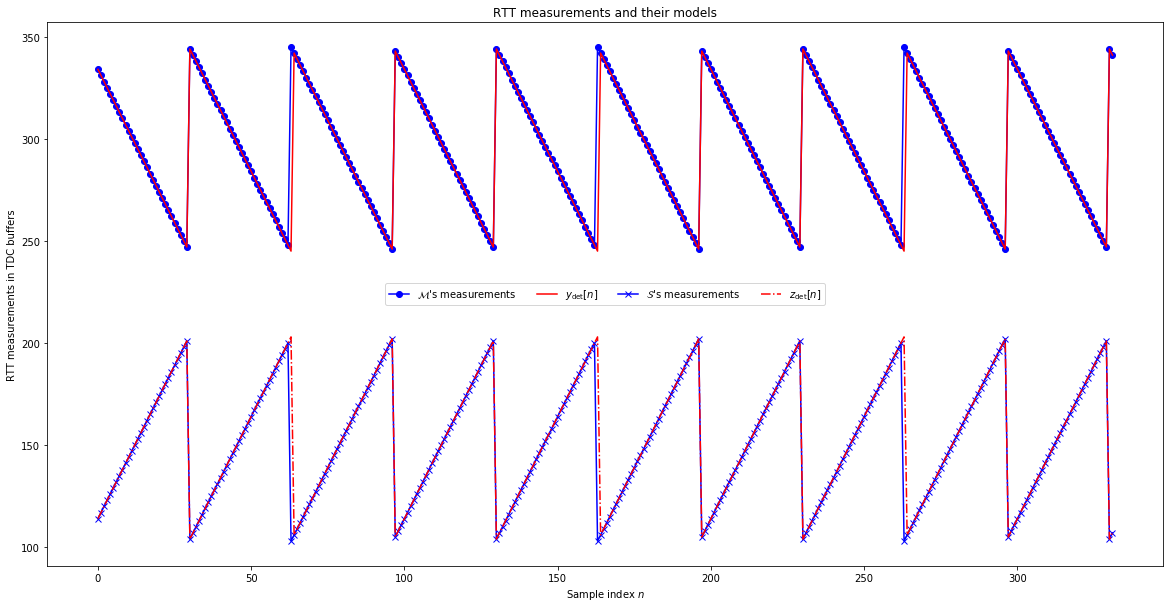

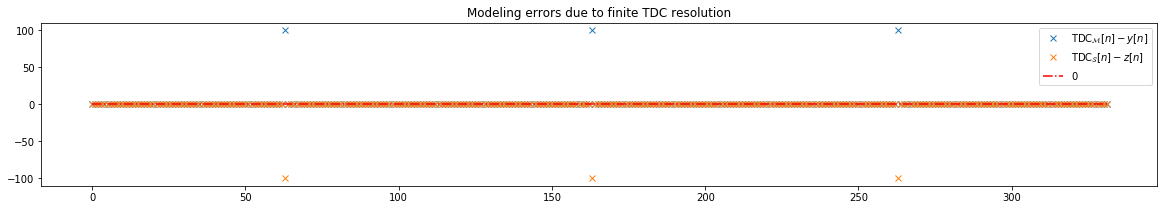

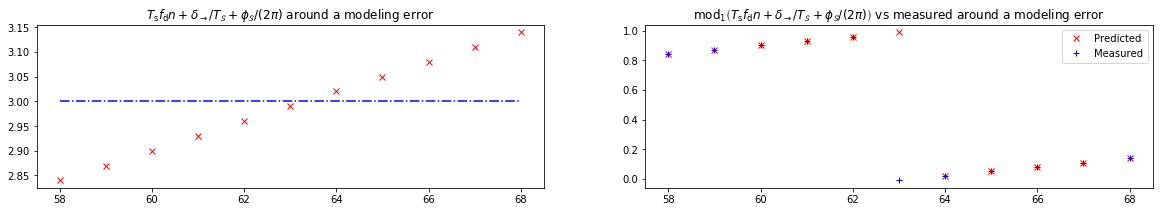

In [19]:
import matplotlib.pyplot as plt

( M_measurements, S_measurements, fd, T_sampling, T_S, phase_S, 
  delay_going_and_back, delay_going, delay_S ) = run_experiment( S_offset = 40 )

# Generate model predictions
# Function for sawtooth component
def h( n ):
    return 1 - (T_sampling*fd*n + delay_going/T_S + phase_S/(2*np.pi) )%(1)
# Signal measured by M (y)
n = np.arange( 0, M_measurements.size, 1 )
y = delay_going_and_back + delay_S + T_S * h(n)
# Signal measured by S (z)
n_S = np.arange( 0, S_measurements.size, 1 )
z = T_sampling - delay_S - T_S * h(n_S) 

# Check model error statistics
diff_y = np.abs( y - M_measurements ) 
diff_z = np.abs( z - S_measurements ) 
print( "The mean absolute deviations (MAD) between measurements and models are (y: %.2f, z: %.2f)"%(
       np.sum( diff_y ) / M_measurements.size, np.sum( diff_z ) / S_measurements.size ) )
print( "The 95%% percentiles of the absolute deviations are (y: %.2f, z:%.2f)"%(
       np.percentile( diff_y, 95 ), np.percentile( diff_z, 95 ) ) )

# Plot measurements vs models
plt.figure( figsize = [20,10] )
plt.plot( n, M_measurements, 'bo-' )
plt.plot( n, y, 'r-' )
plt.plot( n_S, S_measurements, 'bx-' )
plt.plot( n_S, z, 'r-.' )
plt.xlabel( r"Sample index $n$" )
plt.ylabel( r"RTT measurements in TDC buffers" )
plt.legend( [r"$\mathcal{M}$'s measurements", r"$y_{\mathrm{det}}[n]$",
             r"$\mathcal{S}$'s measurements", r"$z_{\mathrm{det}}[n]$"], ncol = 4,
             loc = 'center' );
plt.title( "RTT measurements and their models" )

# Plot modeling errors vs time
plt.figure( figsize = [20,3] )
plt.plot( n, M_measurements - y, 'x', n_S, S_measurements - z, 'x' );
plt.plot( n, np.zeros_like( n ), 'r-.' )
plt.legend( [r"$\mathrm{TDC}_\mathcal{M}[n] - y[n]$", r"$\mathrm{TDC}_\mathcal{S}[n]-z[n]$", r"$0$" ] )
plt.title( "Modeling errors due to finite TDC resolution" )

# Examine modeling errors
# Detect first error and explore the area
error_index = np.where( np.abs( y - M_measurements ) > 0.5 )[0][0]
indices_to_plot = np.arange( error_index-5, error_index+6, 1 )
plt.figure( figsize = [20,3] )
# Compute signal inside non-linearity and integer close to errors
inner_signal = T_sampling*fd*indices_to_plot + delay_going/T_S + phase_S/(2*np.pi)
integer_around = np.unique( np.round( inner_signal ) )
# Show error-provoking phenomenon
plt.subplot(121)
plt.plot( indices_to_plot, inner_signal, 'rx' )
plt.plot( indices_to_plot, integer_around * np.ones_like( indices_to_plot ), 'b-.' )
plt.title( r"$T_\mathrm{s}f_\mathrm{d}n + \delta_{\rightarrow}/T_\mathcal{S} + \phi_\mathcal{S}/(2\pi)$ around a modeling error" )
plt.subplot(122)
plt.plot( indices_to_plot, 1 - h( indices_to_plot ) , 'rx' )
plt.plot( indices_to_plot, 1 - (M_measurements[indices_to_plot] - delay_going_and_back - delay_S)/T_S , 'b+' ) 
plt.legend( ["Predicted", "Measured"] )
plt.title( r"$\mathrm{mod}_1\left(T_\mathrm{s}f_\mathrm{d}n + \delta_{\rightarrow}/T_\mathcal{S} + \phi_\mathcal{S}/(2\pi)\right)$ vs measured around a modeling error" );

<a id="noisy"></a>
### Noisy case

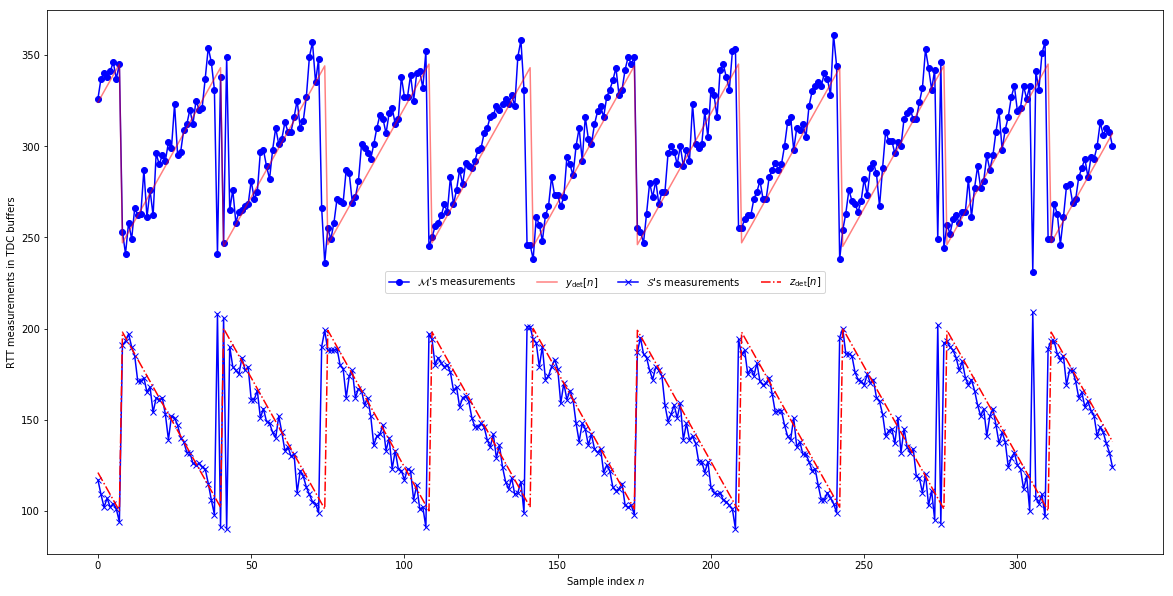

In [25]:
# Seed randomness for reproducibility
np.random.seed(88)

( M_measurements, S_measurements, fd, T_sampling, T_S, phase_S, 
  delay_going_and_back, delay_going, delay_S ) = run_experiment( S_clock_period = 101, M_clock_period = 100,
                                                                 jitter_stds = [0.2, 0.2], 
                                                                 delays_stds = np.array( [5, 8] )  )

# Generate model predictions
# Function for sawtooth component
def h( n ):
    return 1 - (T_sampling*fd*n + delay_going/T_S + phase_S/(2*np.pi) )%(1)
# Signal measured by M (y)
n = np.arange( 0, M_measurements.size, 1 )
y = delay_going_and_back + delay_S + T_S * h(n)
# Signal measured by S (z)
n_S = np.arange( 0, S_measurements.size, 1 )
z = T_sampling - delay_S - T_S * h(n_S) 

# Plot result agains the derived model
plt.figure( figsize = [ 20, 10 ] )

# Plot obtained measurements
plt.plot( n, M_measurements, 'bo-' );
plt.plot( n, y, 'r-', alpha = 0.5 );
plt.plot( n_S, S_measurements, 'bx-' );
plt.plot( n_S, z, 'r-.' )
plt.xlabel( r"Sample index $n$" )
plt.ylabel( r"RTT measurements in TDC buffers" )
plt.legend( [r"$\mathcal{M}$'s measurements", r"$y_{\mathrm{det}}[n]$",
             r"$\mathcal{S}$'s measurements", r"$z_{\mathrm{det}}[n]$"], ncol = 4,
             loc = 'center' );